# Model Inference

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import re
from sklearn.linear_model import LinearRegression

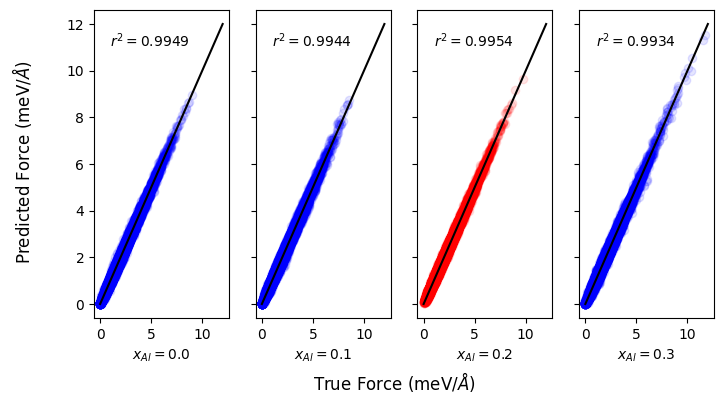

In [22]:
conc = ['00', '10', '20', '30']
fig, axs = plt.subplots(1, len(conc), sharex='row', sharey='row', figsize=(8,4))

true_E = []
error_E = []

for i in range(len(conc)):
    e = pd.read_csv('vasp_inference/Al'+conc[i%4]+'_detailed.e.out', sep=' ', header=None, skiprows=1)
    data_e = e[0].to_numpy()
    pred_e = e[1].to_numpy()
    f = pd.read_csv('vasp_inference/Al'+conc[i%4]+'_detailed.f.out', sep=' ', header=None, skiprows=1)
    data_f = np.linalg.norm(f.to_numpy()[:,0:3], axis=1)
    pred_f = np.linalg.norm(f.to_numpy()[:,3:6], axis=1)

    model = LinearRegression()

    r2 = model.fit(data_e.reshape(-1,1), pred_e).score(data_e.reshape(-1,1), pred_e)
    # print('Al{conc}'.format(conc=conc[i]))
    # print('        Shifted Energy R2:    {r2:.2f}%'.format(r2=100*r2))

    r2 = model.fit(data_f.reshape(-1,1), pred_f).score(data_f.reshape(-1,1), pred_f)
    # print('         Shifted Force R2:    {r2:.2f}%'.format(r2=100*r2))

    color = 'red' if conc[i]=='20' else 'blue'
    axs[i].scatter(data_f, pred_f, c=color, alpha=0.1)
    axs[i].text(1,11, r'$r^2={r2:.4f}$'.format(r2=r2))
    axs[i].plot([0, 12], [0, 12], c='black')
    axs[i].set_xlabel(r'$x_{{Al}}={conc}$'.format(Al="Al", conc=float(conc[i])/100))

    # print('         Mean True Energy:    {E:.4f} eV'.format(E=np.mean(data_e)))
    true_E.append(np.mean(data_e))
    # print('        Mean Energy Error:    {diff:.2f} eV'.format(diff=np.mean(pred_e-data_e)))
    error_E.append(np.mean(pred_e-data_e))

fig.supxlabel(r'True Force (meV/$\AA$)', y=-0.08)
fig.supylabel(r'Predicted Force (meV/$\AA$)')

plt.show()

In [3]:
print((error_E[0] - error_E[1])/(true_E[0] - true_E[1]))
print((error_E[1] - error_E[2])/(true_E[1] - true_E[2]))
print((error_E[2] - error_E[3])/(true_E[2] - true_E[3]))

-3.2752749346212564
-3.5808232730691065
-1.9054554581673486


# Learning Curves

In [4]:
force_av = np.array([])
for name in glob.glob('../MD-VASP/data/LLZO_Ia3d_Al*/OUTCAR'):
    f = open(name, 'r')
    force = np.array([])
    while f:
        line = f.readline()
        if line== "":
            break
        if 'TOTAL-FORCE' in line:
            f.readline()
            data = np.array([])
            for i in range(188):
                line = f.readline()
                values = re.findall(r"[-+]?\d*\.\d+|\d+", line)
                values = [float(x) for x in values]
                data = np.append(data, np.linalg.norm(values[3:]))
            force = np.append(force, data.mean())
    f.close()
    force_av = np.append(force_av, force.mean())

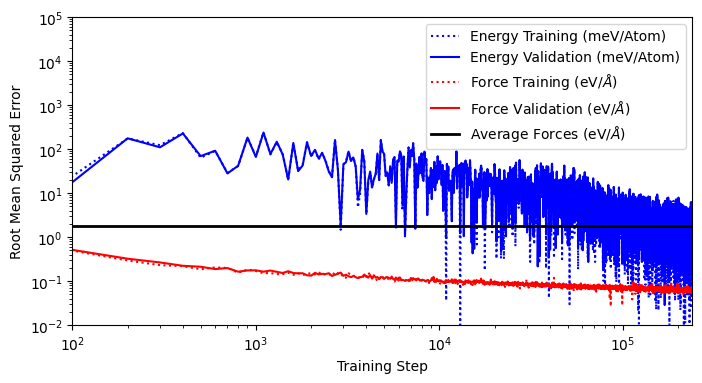

In [14]:
data = np.genfromtxt('model/lcurve.out', names=True)
fig, ax = plt.subplots(1,1, figsize=(8,4))

ax.plot(data['step'], data['rmse_e_trn']*1000,
    linestyle='dotted',
    c='blue',
    label='Energy Training (meV/Atom)')
ax.plot(data['step'], data['rmse_e_val']*1000,
    linestyle='solid',
    c='blue',
    label='Energy Validation (meV/Atom)')
ax.plot(data['step'], data['rmse_f_trn'],
    linestyle='dotted',
    c='red',
    label=r'Force Training (eV/$\AA$)')
ax.plot(data['step'], data['rmse_f_val'],
    linestyle='solid',
    c='red',
    label=r'Force Validation (eV/$\AA$)')
ax.plot([10**2, 2.4*10**5], [np.mean(force_av), np.mean(force_av)], 
    c='k',
    linewidth=2,
    label=r'Average Forces (eV/$\AA$)')

ax.legend(loc='upper right')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([10**2, 2.4*10**5])
ax.set_ylim([10**-2, 10**5])
ax.set_xlabel("Training Step")
ax.set_ylabel("Root Mean Squared Error")


plt.show()